# Ideas

- investigate:
    - nbbo spread effect on customer size
    - nbbo spread effect on price
    - momentum
    - mean reversion
    - beta to esa, beta to other stocks
    - pairs trading

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [169]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# get statsmodels
import statsmodels.api as sm

# Config

In [681]:
_symbols = ["QQQ"]

## time
_num_ticks = 1000000

## bbo generation
_bbo_size = 1000

_size_tick = 10
_price_tick = 0.01

In [682]:
np.random.seed(0)

In [683]:
def create_bbo(prices, fairs, symbol):
    # create dataframe
    df_bbo = pd.DataFrame({"tick": np.arange(_num_ticks), "price": prices, "fair": fairs})

    # create bbo data, size weighted
    df_bbo["symbol"] = symbol

    df_bbo["bid"] = round((df_bbo["price"] - _price_tick) / _price_tick) * _price_tick
    df_bbo["ask"] = round((df_bbo["price"] + _price_tick) / _price_tick) * _price_tick

    df_bbo["bidsz"] = _bbo_size * (df_bbo["price"] - df_bbo["bid"]) / _price_tick
    df_bbo["asksz"] = _bbo_size - df_bbo["bidsz"]

    clean_fn = lambda x : np.maximum(_size_tick, x // _size_tick * _size_tick).astype(int)
    df_bbo["bidsz"] = clean_fn(df_bbo["bidsz"])
    df_bbo["asksz"] = clean_fn(df_bbo["asksz"])
    
    # mid calculations
    df_bbo["mid"] = df_bbo.eval("(bid + ask) / 2")
    df_bbo["smid"] = df_bbo.eval("(bid * asksz + ask * bidsz) / (bidsz + asksz)")

    
    return df_bbo

In [684]:
## Create QQQs
# create time series data

def create_liquid_bbo(symbol, initial_price, fair_stdev):
    fair_chgs = np.random.normal(loc=0, scale=fair_stdev, size=_num_ticks)
    fairs = initial_price * np.exp(np.cumsum(fair_chgs))

    df_bbo = create_bbo(
        prices=fairs,
        fairs=fairs,
        symbol=symbol,
    )
    
    return df_bbo

In [685]:
# create index
df_index = create_liquid_bbo(
    symbol="QQQ",
    initial_price=100,
    fair_stdev=1e-4,
)

In [ ]:
# create new bbos
# symbol = "Tech1"
# sym_beta = 2.5
# sym_initial_price = 1000
# sym_self_stdev = 1e-4
# sym_converge_rate = 0.02

def create_stock_bbo(symbol, df_index, beta, initial_price, fair_stdev, converge_rate):

    fair_chgs_self = np.random.normal(loc=0, scale=fair_stdev, size=_num_ticks)
    fairs_self = initial_price * np.exp(np.cumsum(fair_chgs_self))
    
    index_fair_chgs = np.log(df_index["fair"] / df_index["fair"].shift()).fillna(0)
    
    # compute fair from self-moves + index-moves
    fairs = fairs_self * np.exp(beta * np.cumsum(index_fair_chgs))

    # actual prices
    cur_price = initial_price
    prices = [cur_price]

    for tick in range(1, _num_ticks):
        # adjust to true fair
        cur_price = cur_price + (fairs[tick] - cur_price) * converge_rate
        prices += [cur_price]

    prices = np.array(prices)

    df_bbo = create_bbo(
        prices=prices,
        fairs=fairs,
        symbol=symbol,
    )
    
    return df_bbo

In [686]:
df_bbo_sym = create_stock_bbo(
    symbol="Tech1",
    df_index=df_index,
    beta=2.5,
    initial_price=1000,
    fair_stdev=1e-4,
    converge_rate=0.02,
)

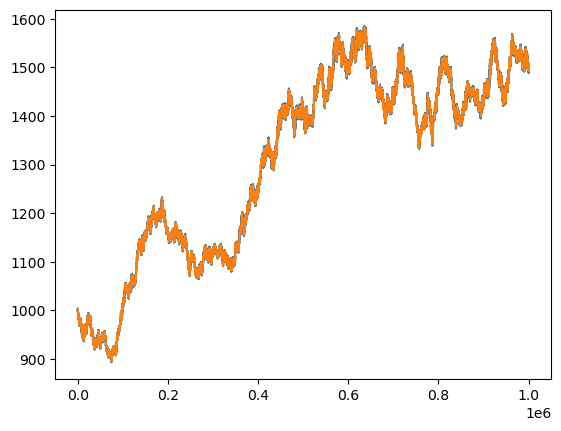

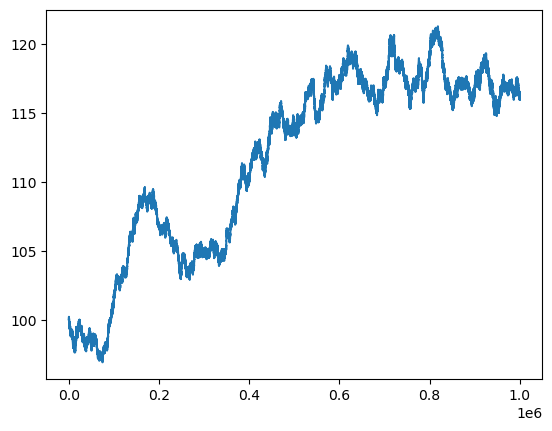

In [687]:
plt.plot(df_bbo_sym["fair"])
plt.plot(df_bbo_sym["price"])
plt.show()
plt.plot(df_index["fair"])

In [688]:
df_bbo_sym

,tick,price,fair,symbol,bid,ask,bidsz,asksz,mid,smid
0,0,1000.000000,1000.051426,Tech1,999.99,1000.01,990,10,1000.00,1000.009800
1,1,1000.005256,1000.262785,Tech1,1000.00,1000.02,520,470,1000.01,1000.010505
2,2,1000.016653,1000.575103,Tech1,1000.01,1000.03,660,330,1000.02,1000.023333
3,3,1000.037913,1001.079687,Tech1,1000.03,1000.05,790,200,1000.04,1000.045960
4,4,1000.066427,1001.463575,Tech1,1000.06,1000.08,640,350,1000.07,1000.072929
...,...,...,...,...,...,...,...,...,...,...
999995,999995,1500.177345,1503.738425,Tech1,1500.17,1500.19,730,260,1500.18,1500.184747
999996,999996,1500.247902,1503.705213,Tech1,1500.24,1500.26,790,200,1500.25,1500.255960
999997,999997,1500.305583,1503.131942,Tech1,1500.30,1500.32,550,440,1500.31,1500.311111
999998,999998,1500.367691,1503.410991,Tech1,1500.36,1500.38,760,230,1500.37,1500.375354


In [689]:
# get true betas
stock_chgs = np.log(df_bbo_sym["fair"].shift(-1) / df_bbo_sym["fair"]).fillna(0)
index_chgs = np.log(df_index["fair"].shift(-1) / df_index["fair"]).fillna(0)


In [690]:
X = index_chgs.to_numpy().reshape(len(index_chgs), 1)
y = np.array(stock_chgs)


model = LinearRegression(fit_intercept=False).fit(X, y)
beta = model.coef_[0]
r2 = model.score(X, y)

print("beta", beta)
print("r2", r2)


beta 2.500621515481523
r2 0.8623737726890452


In [749]:
""" HELPERS """
def create_windows(rng):
    rng = sorted(set(list(rng) + [0]))
    return [(rng[i], rng[i + 1]) for i in range(len(rng) - 1)]

def get_rtn_col(window):
    return f"rtn_{window[0]}_{window[1]}s"

def get_rtn_cols(windows):
    return [get_rtn_col(win) for win in windows]





def compute_marks(df_bbo, windows, mid_col):
    # init new df
    df_mark = df_bbo[["tick", "symbol", "mid", "smid"]].copy()
    
    # add marks for all mark_times
    for int_lb, int_ub in windows:
        ser1 = df_mark[mid_col].shift(-1 * int_lb)
        ser2 = df_mark[mid_col].shift(-1 * int_ub)
        df_mark[get_rtn_col((int_lb, int_ub))] = np.log(ser2 / ser1)

    df_mark = df_mark.copy().dropna()
    return df_mark



In [789]:
pred_windows = [(-5, 0)]

resp_windows = create_windows(np.arange(-5, 200 + 1, 5))
# create_windows(-1 * np.geomspace(1, 1200, 50).round().astype(int))


df_mark1 = compute_marks(
    df_bbo=df_index, 
    windows=pred_windows, 
    mid_col="mid",
)
df_mark1 = df_mark1.add_suffix("_pred")

df_mark2 = compute_marks(
    df_bbo=df_bbo_sym, 
    windows=resp_windows, 
    mid_col="mid",
)



In [790]:
# use various mark times

all_data = []

# get columns
xcols = list( pd.Series(get_rtn_cols(pred_windows)) + "_pred" )
ycols = get_rtn_cols(resp_windows)

# add_suffix + merge + dropna
df = df_mark1.merge(df_mark2, left_on="tick_pred", right_on="tick")
df = df.dropna()


all_data = []

for ycol, resp_win in zip(ycols, resp_windows):

    X = df[xcols]
    y = df[ycol]

    # indexes
    all_windows = [pred_windows, resp_win]
    keep_freq = max(np.max(wins) for wins in all_windows) - min(np.min(wins) for wins in all_windows)
    idxs = np.arange(0, len(X), keep_freq)
    X = X.iloc[idxs]
    y = y.iloc[idxs]

    model = LinearRegression(fit_intercept=False).fit(X, y)
    betas = model.coef_[0]

    ypred = model.predict(X)
#     r2s = r2_score(y, ypred, multioutput="raw_values")
    r2s = r2_score(y, ypred)
    
    # fit ols
    ols = sm.OLS(y, X).fit()
    tstat = ols.tvalues[xcols[0]]
    
    # betas
#     df_beta = pd.DataFrame({"beta": betas, "window": resp_windows})
#     df_beta["avg_window"] = -1 * df_beta["window"].apply(lambda x: (x[0] + x[1]) / 2)
#     df_beta

    
    all_data += [{
        "beta": betas, "r2": r2s, "tstat": tstat, 
        "keep_freq": keep_freq, 
        "resp_win1": resp_win[0], "resp_win2": resp_win[1], 
        "avg_win": np.mean(resp_win),
    }]
    
#     display(ols.summary())
#     print(all_data)
#     break
    
df_beta = pd.DataFrame(all_data)
df_beta["abs_tstat"] = df_beta["tstat"].abs()

In [791]:
from scipy.optimize import curve_fit

In [792]:
def exp_fn(x, a, b):
    return a * np.exp(b * x)

def fit_helper(p0):
    return curve_fit(exp_fn, df_beta["avg_win"], df_beta["beta"], p0=p0)
    

popt, pcov = fit_helper(p0=(-2.5, 0.1))
if round(popt[0], 6) == 0:
    popt, pcov = fit_helper(p0=(-2.5, -0.1))
    if round(popt[0], 6) == 0:
        assert False, popt


curve_fn = lambda x: exp_fn(x, *popt)

popt

array([ 0.20344563, -0.01854936])

In [793]:
# predict betas
df_beta["beta_pred"] = curve_fn(df_beta["avg_win"])

# get contemp betas
np.round([np.sum(df_beta["beta"]), np.sum(df_beta["beta_pred"])], 2)

array([2.3 , 2.35])

Text(0, 0.5, 'beta')

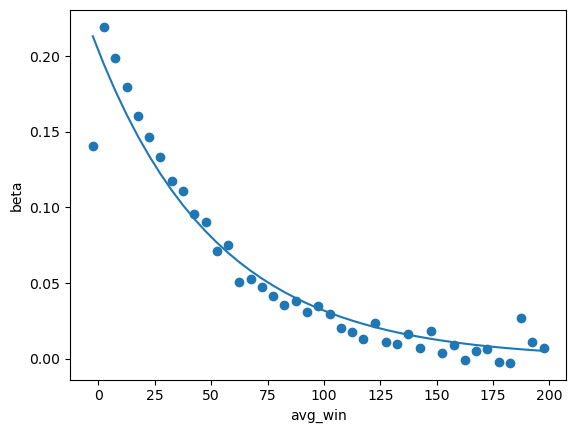

In [794]:
# windows vs betas
plt.scatter(df_beta["avg_win"], df_beta["beta"])
plt.plot(df_beta["avg_win"], df_beta["beta_pred"])

plt.xlabel("avg_win")
plt.ylabel("beta")

In [795]:
# get contemp betas
np.sum(df_beta["beta"]), np.sum(df_beta["beta_pred"])

(2.301785883605321, 2.3521957724658433)

In [796]:
abs(popt[0] / popt[1]) / 5

2.193560110338404

- check if big bid/ask is still strong signal in yesterday's data
- check if 

In [1030]:
_eps = 1e-8

In [1031]:
## test closing strategies

fair = 100
initial_price = 100
initial_shares = 10000

impact = 0.1 # buying 1 dollar moves share by 0.1
discount_factor = 0.01 # 1% per step

timesteps = 10000


In [1087]:
def close_fractional(
    fair, 
    cur_price, 
    cur_shares, 
    time_left, 
    discount_factor, 
    impact,
):
    
    return cur_shares / time_left

def close_constant_price(
    fair, 
    cur_price, 
    cur_shares, 
    time_left, 
    discount_factor, 
    impact, # impact constant
):
    if time_left == 1:
        return cur_shares
    
    
    cur_shares_imp = cur_shares * impact
    
    # get initial size
    init_size_imp = ((1 - discount_factor) * cur_shares_imp / time_left - discount_factor * (cur_price - fair)) \
                        / (discount_factor + (1 - discount_factor) / time_left)
    init_size = init_size_imp / impact
    
    # find shares left and split that evenly over the remaining time
    shares_left = cur_shares - init_size
    assert shares_left > 0 - _eps
    
    repeat_size = shares_left / time_left
    total_size = init_size + repeat_size
    
    if time_left == 1000:
        print("fair", fair, cur_price, cur_shares, time_left, discount_factor, impact)
        print("cur_share_imp", round(cur_shares_imp, 3))
        print("init_size_imp", round(init_size_imp, 3), round(init_size, 3))
        print("shares_left", round(shares_left, 3), round(repeat_size, 3), round(total_size, 3))
    
    if total_size > 0:
        return total_size
    else:
        return 0
    

def close_constant_price2(
    fair, 
    cur_price, 
    cur_shares, 
    time_left, 
    discount_factor, 
    impact, # impact constant
):
    if time_left == 1:
        return cur_shares
    
    
    cur_shares_imp = cur_shares * impact
    
    # get initial size
    init_size_imp = ((1) * cur_shares_imp / time_left - discount_factor * (cur_price - fair)) \
                        / (discount_factor + (1) / time_left)
    init_size = init_size_imp / impact
    
    # find shares left and split that evenly over the remaining time
    shares_left = cur_shares - init_size
    assert shares_left > 0 - _eps
    
    repeat_size = shares_left / time_left
    total_size = init_size + repeat_size
    
    if time_left == 1000:
        print("fair", fair, cur_price, cur_shares, time_left, discount_factor, impact)
        print("cur_share_imp", round(cur_shares_imp, 3))
        print("init_size_imp", round(init_size_imp, 3), round(init_size, 3))
        print("shares_left", round(shares_left, 3), round(repeat_size, 3), round(total_size, 3))
    
    if total_size > 0:
        return total_size
    else:
        return 0
    
    

In [1088]:
# constant closing

def test_closing_strategy(
    close_fn,
    fair, 
    initial_price, 
    initial_shares, 
    timesteps, 
    discount_factor, 
    impact, 
):
    cur_price = initial_price
    cur_shares = initial_shares
    
    all_data = []
    for t in range(timesteps):
        # move to fair
        cur_price = cur_price + (fair - cur_price) * discount_factor

        # get trades
        trade_size = close_fn(
            fair, 
            cur_price, 
            cur_shares, 
            time_left=timesteps - t,
            discount_factor=discount_factor,
            impact=impact,
        )
        
        # apply trade
        new_price = cur_price + trade_size * impact
        trade_price = (cur_price + new_price) / 2

        cur_shares -= trade_size
        cur_price = new_price

        all_data += [{"time": t, "price": cur_price, "trade_price": trade_price, "trade_size": trade_size, "cur_shares": cur_shares}]

    assert cur_shares == 0
    
    df_tick = pd.DataFrame(all_data)
    avg_price = df_tick.eval("trade_price * trade_size").sum() / df_tick["trade_size"].sum()
    
    
    return df_tick, avg_price

## Initial study
- model of world:
    - there's a market maker that fades linearly by deltas
    - there's a taker bot that trades towards fair. Each second, they move the price towards fair by some fraction of the distance.
- goal:
    - if we have to close our size within some time frame, how much will it cost to do so?
        - what is the cheapest method?
        - the exact cost depends on a few factors
            - our total price impact (if we closed instantly)
            - discount factor (the fraction that taker bot moves to fair, per second)
            - how much time we have to close
    - use these numbers to determine our fade function
        - the 

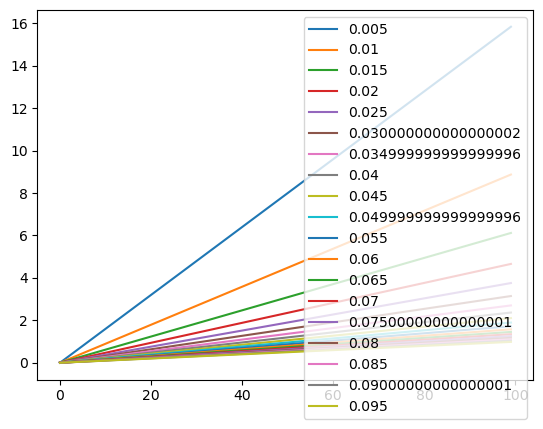

In [952]:
# initial study
slopes = []

discounts = np.arange(0.005, 0.005*20, 0.005)

for discount_factor in discounts:
    all_data = []
    
    for total_impact in range(100):

        initial_shares = 10000
        impact = total_impact / initial_shares

        df_tick, avg = test_closing_strategy(
            close_fn=close_fractional,
            fair=100,
            initial_price=100,
            initial_shares=initial_shares,
            timesteps=1000,
            discount_factor=discount_factor,
            impact=impact,
        )

        all_data += [{"total_impact": total_impact, "impact": impact, "edge_paid": avg - 100}]

    df_res = pd.DataFrame(all_data)
    plt.plot(df_res["edge_paid"], label=f"{discount_factor}")
    
    slopes += [all_data[1]["edge_paid"]]
    
plt.legend()

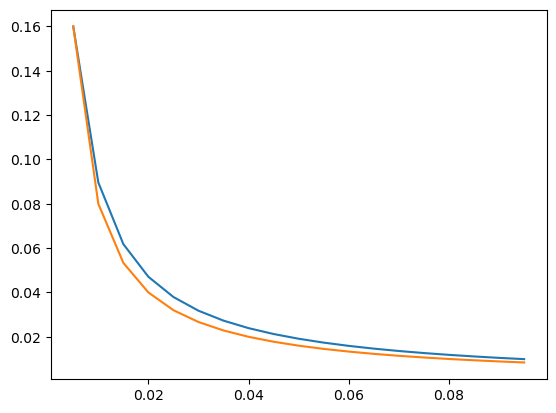

In [958]:
# result:
# fade ~~~ 1 / discount_rate (approx)
# fade ~~~ 1 / (1 - (1-c)^x) (more exact)
# c is discount rate, x is time left
df = pd.DataFrame({"slope": slopes, "discount": discounts})

plt.plot(df["discount"], df["slope"])
plt.plot(df["discount"], (1 / df["discount"]) * df["slope"][0] * df["discount"][0])

## Study with real numbers

In [1089]:
def convert_discount_time(c0, x0, x1):
#     v = 1 / (1 - (1 - c0) ** x0)
#     c1 = 1 - (1 - 1/v) ** (1 / x1)
    c1 = 1 - (1 - c0) ** (x0 / x1)
    return c1


fair 100 100.0 10000 1000 0.19999999999999996 0.01
cur_share_imp 100.0
init_size_imp 0.398 39.841
shares_left 9960.159 9.96 49.801


,total_impact,duration,edge_paid
0,1.0,1000,0.447215


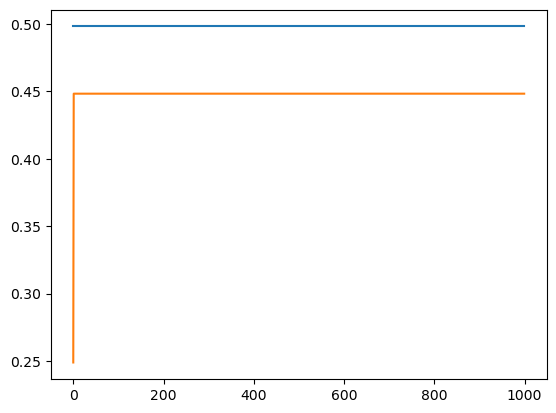

In [1092]:
# parameters
total_impact = 0.01 * 100
discount_factor = 0.2 # fade amounts
# tested_times = list(range(30, 30 * 20 * 1, 30))
tested_times = [1000]

# constants (unlikely that you need to change this)
initial_shares = 10000 # arbitrary number, larger might be good for numerical accuracy
timesteps_sim = 1000 # larger is probably better, but execution speed scales linearly
fair = 100 # arbitrary, larger might be good for numerical accuracy

all_data = []

for timesteps_real in tested_times:
    unit_impact = (fair * total_impact) / initial_shares

    discount_sim = convert_discount_time(c0=discount_factor, x0=timesteps_real, x1=timesteps_sim)
#     print(timesteps_real, discount_factor, timesteps_sim, discount_sim)
    
    df_tick, avg = test_closing_strategy(
        close_fn=close_constant_price,
#         close_fn=close_fractional,
        fair=fair,
        initial_price=fair,
        initial_shares=initial_shares, ## arbitrary number
        timesteps=timesteps_sim,
        discount_factor=discount_sim,
        impact=unit_impact,
    )

    all_data += [{"total_impact": total_impact, "duration": timesteps_real, "edge_paid": avg - fair}]
#     break

df_res = pd.DataFrame(all_data)
plt.plot(df_tick["price"] - fair)
plt.plot(df_tick["trade_price"] - fair)

df_res.head(3)
